<a id='top'></a>
# Project: Investigating no-shows at medical appointments in Brazil


## Table of Contents
<ul>
<p>
    <li><a href="#intro">Introduction</a></li>

    <li><a href="#wrangling">Data wrangling</a></li>
        <ul>
            <li><a href="#gprop">General properties</a></li>
            <li><a href="#cleaning">Columns and data cleaning</a></li>
                <ul>
                    <li><a href="#scheduled_day">scheduled_day</a></li>
                    <li><a href="#appointment_day">appointment_day</a></li>
                    <li><a href="#patient_ID">patient_ID</a></li>
                    <li><a href="#appointment_ID">appointment_ID</a></li>
                    <li><a href="#gender">gender</a></li>
                    <li><a href="#age">age</a></li>
                    <li><a href="#neighbourhood">neighbourhood</a></li>
                    <li><a href="#boolcols">SMS_received, scholarship, hypertension, diabetes and alcoholism</a></li>
                    <li><a href="#handicap">handicap</a></li>
                    <li><a href="#no_show">no_show</a></li>
                </ul>
            <li><a href="#checks">Consistency checks</a></li>
                <ul>
                    <li><a href="#con_check_patient">Consistency of patient attributes within patient IDs</a></li>
                    <li><a href="#con_check_dates">Chronological order of appointment_day and scheduled_day</a></li>
                </ul>
        </ul>
    <li><a href="#eda">Exploratory data analysis</a></li>
        <ul>
            <li><a href="#same_day">Same day appointments</a></li>
            <li><a href="#smsvlead">SMS_received and its relationship with lead_days</a></li>
            <li><a href="#boolandage">The boolean patient attributes and age_group</a></li>
            <li><a href="#history">No-show history</a></li>
            <li><a href="#hour">No-show rates by scheduled_hour</a></li>
            <li><a href="#neighbourhoodvnoshow ">No-show rates by neighbourhood</a></li>
            
        </ul>
    <li><a href="#conclusions">Conclusions</a></li>
</pre>
</ul>

<a id='intro'></a>
## Introduction

In this project we investigate a data set of appoinment records in public hospitals in Vitoria, Espirito Santo, Brazil. The data includes whether the patient showed up to the appointment, which is the main focus, as well as other attributes of the patient and the appointment. 

The data set is provided by JoniHoppen on Kaggle: https://www.kaggle.com/joniarroba/noshowappointments

Our aim is to help to answer the question, "how likely is a patient with certain attributes, to show up to his hospital appointment?" We will explore the data and look for relationships between variables, to pave the way for more extensive modeling.

<div style="text-align: right"> <a href="#top">to top</a> </div>

<a id='wrangling'></a>
## Data Wrangling

<a id='gprop'></a>
### General Properties  
Here we'll import the CSV file and look at some general properties of the data set.

<div style="text-align: right"> <a href="#top">to top</a> </div>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import collections
import statsmodels.stats.proportion
%matplotlib inline

In [3]:
def bold(text):
    '''Returns the input-ted text in bold'''
    return '\033[1m' + text + '\033[0;0m'

In [4]:
# Load the data from the CSV and print some basic info and the 
# first entry as a sample

appointments_df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

print(appointments_df.info())
print(appointments_df.describe())
print(appointments_df.iloc[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None
          PatientId  AppointmentID            Age    Scholarship  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06      37.088874       0.098266   
std    2.560949e+14   7.129575e+04      23.110205 

We have a single 2D table with 14 columns and 110527 rows.

For consistency and to reduce errors, columns will be renamed in snake_case.
Handcap and Hipertension will have their spellings changed into handicap and hypertension respectively.

In [5]:
appointments_df.columns = [
    'patient_ID', 'appointment_ID', 'gender', 'scheduled_day',
    'appointment_day', 'age', 'neighbourhood', 'scholarship',
    'hypertension', 'diabetes', 'alcoholism', 'handicap', 'SMS_received',
    'no_show'
    ]

<a id='cleaning'></a>
### Columns and data cleaning

We'll take a look at each of the columns, clean and/or modify them and add new columns as needed.

<div style="text-align: right"> <a href="#top">to top</a> </div>

<a id='scheduled_day'></a>
#### *scheduled_day*

This column is the date and time of when the appointment is made.

We'll parse it in place. And for analysis we'll create a new column:

> ** *scheduled_hour* **  
Hour of the time at which the appointment is made as integer

<div style="text-align: right"> <a href="#top">to top</a> </div>

In [6]:
appointments_df.scheduled_day = pd.to_datetime(appointments_df.scheduled_day)
appointments_df['scheduled_hour'] = (
    appointments_df.scheduled_day.apply(lambda x : x.hour)
    )

<a id='appointment_day'></a>
#### *appointment_day*

This column is the date of the appointment. There is a time element in the column but it is all 00:00:00 which means the time of the appointment is not recorded.

Again we'll parse the column into datetime format in place. In addition we'll create three columns: 

> ** *lead_days* **  
Since we don't have the time for the appointment, we'll just compute the difference in days between the *scheduled_day* and *appointment_day*, assuming all scheduling is done at 00:00:00.  

> As such,  same-day appointments should show a 0. Any value < 0 means there may be something wrong with the data as it doens't make sense for the appointment to happen before the scheduling.

> ** *lead_days_category* **  
Appointments start to get sparse as *lead_days* increases. To avoid the problem of some *lead_day* values having very few samples, or even none, we bin *lead_days* into categories.
The bins are not uniform, because as we shall see, same-day appointments are very different from where *lead_days* is 1 or 2, which, in turn, are different from the rest in some important aspects.

> ** *appointment_DOW* **  
For the day-of-week of the *appointment_day*. Mondays are 0 and Sundays are 6.

<div style="text-align: right"> <a href="#top">to top</a> </div>

In [7]:
def get_day(datetime_object):
    '''This function returns only the date part of a datetime'''
    return datetime_object.date()

# Parse the date from string
appointments_df.appointment_day = pd.to_datetime(appointments_df.appointment_day)
# Get lead_days column in timedelta64[ns] format
appointments_df['lead_days'] = (
    appointments_df.appointment_day.apply(get_day)
    - appointments_df.scheduled_day.apply(get_day)
    )
# Change the datatype into integer
appointments_df.lead_days = (
    (appointments_df.lead_days.astype('timedelta64[D]')).astype(int)
    )
# Create the appointment day-of-week column
appointments_df['appointment_DOW'] = (
    appointments_df.appointment_day.dt.dayofweek
    )

In [8]:
# Create lead_days_category column
lead_days_labels = pd.Series([
    'A: Same day',
    'B: 1-2 days',
    'C: 3-7 days',
    'D: 8-31 days',
    'E: 32+ days'
    ])
appointments_df['lead_days_category'] = pd.cut(
    appointments_df.lead_days, bins = [-1, 0, 2, 7, 31, 999],
    labels = lead_days_labels,
    )
# Change dtype to string because when data in this column is put into the
# comparison_df in the compare_by_column(df, column_name) function later on,
# an 'overall' row can be appended to string values but not categorical values.
appointments_df.lead_days_category = (
    appointments_df.lead_days_category.astype('str')
    )

<a id='patient_ID'></a>
#### *patient_ID*
This column is, as the name indicates, the ID of the patient.

The datatype is float so we have to look for values with decimal points, and try to figure out why.

We'll also look at the patient IDs that appear most often in our data set, to look for potential errors.

<div style="text-align: right"> <a href="#top">to top</a> </div>

In [9]:
# To make sure decimals get displayed
pd.set_option('display.float_format', '{:9f}'.format)
print(
    bold('Number of unique patient IDs:'),
    len(appointments_df.patient_ID.unique())
    )
print(' ')
print(bold('Patient IDs with decimal places: '))
print(
    appointments_df[~ appointments_df.patient_ID
    .apply(lambda x: x.is_integer())]
    )

Number of unique patient IDs: 62299
 
Patient IDs with decimal places: 
          patient_ID  appointment_ID gender       scheduled_day  \
3950    93779.529270         5712759      F 2016-05-18 09:12:29   
73228  537615.284760         5637728      F 2016-04-29 07:19:57   
73303  141724.166550         5637648      M 2016-04-29 07:13:36   
100517  39217.844390         5751990      F 2016-05-31 10:56:41   
105430  43741.756520         5760144      M 2016-06-01 14:22:58   

       appointment_day  age   neighbourhood  scholarship  hypertension  \
3950        2016-05-18   33          CENTRO            0             0   
73228       2016-05-06   14  FORTE SÃO JOÃO            0             0   
73303       2016-05-02   12  FORTE SÃO JOÃO            0             0   
100517      2016-06-03   44    PRAIA DO SUÁ            0             0   
105430      2016-06-01   39     MARIA ORTIZ            0             0   

        diabetes  alcoholism  handicap  SMS_received no_show  scheduled_hour  \


There are 5 entries with non-integer patient IDs. The obvious guess is that the decimal points were typos.

We've checked if the decimal points are removed, whether these patient IDs would appear in other records (e.g. a patient made two appointments, and during data input in one appointment, the patient ID was incorrectly input-ted)

Turns out none of the 5 patient IDs, after the decimal points are removed, match the patient ID of any other entry. (code and result not shown here)

The best assumption we can make is that they are all unique. Since the *patient_ID* column is just an identifier in our study, it shouldn't be too much of a problem.

To leave room for future correction, we will just leave those entries as they are.

In [10]:
# Take a look at the patients with the most number of appointments
# in our dataset.
# To trim the 0s in the IDs
pd.set_option('display.float_format', '{:.0f}'.format) 
print(bold('Patients with the most appointments: '))
print(appointments_df.patient_ID.value_counts().iloc[0:10])
pd.set_option('display.float_format', '{:4f}'.format) 

Patients with the most appointments: 
822145925426128    88
99637671331        84
26886125921145     70
33534783483176     65
258424392677       62
75797461494159     62
871374938638855    62
6264198675331      62
66844879846766     57
872278549442       55
Name: patient_ID, dtype: int64


There are some patients with 50+ appointments in our dataset that spans a little more than a month. This sounds like a lot but it's not impossible, especially if the hospital counts consecutive visits to different departments for the same case as different appointments, or if they count consultations or treatment of inpatients as appointments. 

In fact, most of the appointments made by the top 3 most frequent patients are same-day appointments.  

Going through the first few patients manually, nothing looking out of place was found. 

Later in this study a consistency check will be done, and we'll see that all rows with the same *patient_ID* have the same values for various attribute columns, and that none of the *age* values of rows with the same *patient_ID* differ by more than 1.

<a id='appointment_ID'></a>
#### *appointment_ID*

As each row represents one appointment, the *appointment_ID* values should be unique. We'll check if that is the case. And if it is, we'll use the column as the index.

<div style="text-align: right"> <a href="#top">to top</a> </div>

In [11]:
len(appointments_df.appointment_ID.unique())

110527

The number of unique *appointment_ID* values, 110527, is the same as the number of rows. That means all *appointment_ID* are unique.

We'll make appointment ID the index.

In [12]:
appointments_df.set_index('appointment_ID', inplace = True)

<a id='gender'></a>
#### *gender*
This column is in string. 'F' for female and 'M' for male.
<div style="text-align: right"> <a href="#top">to top</a> </div>

In [13]:
print(bold('Counts by gender: '))
appointments_df.gender.value_counts()

Counts by gender: 


F    71840
M    38687
Name: gender, dtype: int64

Female patients make up almost two thirds of the visits. Interesting number, but we can't say we've spotted anything unreasonable.

We'll add new column, for easier access:
> ** *is_female* **  
Boolean values where True stands for female.

In [14]:
appointments_df['is_female'] = (appointments_df.gender == 'F')

<a id='age'></a>
#### *age*

We'll look at the range and the values with the most counts to look for possible errors. 

<div style="text-align: right"> <a href="#top">to top</a> </div>

In [15]:
pd.options.display.max_rows = 10
print(bold('Counts by age: '))
print(appointments_df.age.value_counts().sort_index())
print(appointments_df.age.value_counts().sort_values(ascending = False).head())

Counts by age: 
-1         1
 0      3539
 1      2273
 2      1618
 3      1513
        ... 
 98        6
 99        1
 100       4
 102       2
 115       5
Name: age, Length: 104, dtype: int64
0     3539
1     2273
52    1746
49    1652
53    1651
Name: age, dtype: int64


We've found that the 5 appointments with *age* 115 were made by 2 patients. Although it is very rare for a person to be 115 years old, we can't say having 2 cases in our sample is impossible.

For the case where the *age* is -1, on Kaggle the provider of the data set explained it indicates an unborn baby. The discussion is going on regarding why is the fetus, rather than the mother, being registered as the patient, as well as why is there only one single entry with that value.

For now we'll just leave the entry as is. 

At higher ages, counts start to get sparse, therefore we'll bin the *age* values and put it in a new column:
> ** *age_group* **  
0-9 will be group 0, 10-19 will be group 1, 20-29 will be group 2, etc. Since ages 100 or above are rare, we'll put any *age* 90 or above into group 9. The single case of the *age* being -1 will also be in group 0.

In [16]:
appointments_df['age_group'] = (
    appointments_df.age.apply(lambda x: min(int(x / 10) , 9))
    )
appointments_df.age_group.value_counts().sort_index()

0    17476
1    12936
2    13699
3    15171
4    14209
5    15863
6    11876
7     5934
8     2946
9      417
Name: age_group, dtype: int64

<a id='neighbourhood'></a>
#### *neighbourhood*

According to the provider of the data, this column records the neighbourhood of the hospital in which the appointment is carried out. It is possible for patients to come from outside of the neighbourhood, or even the city. 

<div style="text-align: right"> <a href="#top">to top</a> </div>

In [17]:
# number of unique neighbourhood values
len(appointments_df.neighbourhood.unique())

81

There are 81 of these neighbourhoods in our data set and all of them are in the city of Vitória, Brazil.

<a id='boolcols'></a>
#### *SMS_received*, *scholarship*, *hypertension*, *diabetes* and *alcoholism*

*SMS_received* indicates whether an SMS message was sent to the patient to remind them of the appointment.

*scholarship* indicates whether the patient is covered by Bolsa Família, a social welfare program in Brazil.

*hypertension*, *diabetes* and *alcoholism* are what their names indicate respectively. We'll change these three columns, as well as *scholarship*, into booleans for easier access.

<div style="text-align: right"> <a href="#top">to top</a> </div>

In [18]:
columns_to_change = [
    'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'SMS_received'
    ]
for column in columns_to_change:
    appointments_df[column] = (appointments_df[column] == 1)

<a id='handicap'></a>
#### *handicap*

This column contains a integer ranging from 0 to 4, indicating the number of handicaps the patient is suffering from.

Values 2 to 4 are rare. We'll group all > 0 cases together and create a new column: 
> ** *is_handicapped* **  
A boolean column where True stands for the presence of any handicap.

<div style="text-align: right"> <a href="#top">to top</a> </div>

In [19]:
appointments_df['is_handicapped'] = (appointments_df.handicap > 0)

<a id='no_show'></a>
#### *no_show*

This column takes string values of either 'Yes' or 'No'. A 'Yes' indicates the patient DID NOT show up for the appointment.

We'll first change it into a booleans for easier access, and then create a new column:

> ** *no_show_last_time* **  
Shows whether the same patient has failed to show up in the last appointment included in our study.  

> Our data set includes appointments spanning only a little more than a month, there will likely be many patients who have had previous appointments that is not included, and thus this column will include many NaNs.  

> Between appointments on the same day, whichever was scheduled earlier is assumed to be the earlier appointment. This may cause problems in analysis in the future.

<div style="text-align: right"> <a href="#top">to top</a> </div>

In [20]:
boolean_replacement = {'Yes': True, 'No': False}
appointments_df.no_show.replace(boolean_replacement, inplace = True)

In [21]:
# create a new column no_show_last_time that takes the value of no_show in
# the previous appointment of the same patient
appointments_df = appointments_df.sort_values(
    by = ['appointment_day', 'scheduled_day'], axis = 0
    )
appointments_df['no_show_last_time'] = (
    appointments_df.groupby('patient_ID')['no_show'].apply(lambda x : x.shift(1))
    )

<a id='checks'></a>
### Consistency checks

<a id='con_check_patient'></a>
#### Consistency of patient attributes within patient IDs
First we'll check if there is any entry with the same *patient_ID* but different values for the columns *gender*, *hypertension*, *diabetes*, *alcoholism*, *scholarship*, *handicap*. It is quite unlikely for these values to change over the course of 40 days - the period during which all the appointments lie.

Then we'll look for entries with the same *patient_ID* and differ in *age* by more than 1 as it is impossible for to be more than 1 year older within the 40 days we are looking at.

<div style="text-align: right"> <a href="#top">to top</a> </div>

In [22]:
def check_patient_status_consistency(column_to_check):
    '''
    Takes in a column (meant to be grouped by patient ID), and returns
    False if not all the values are the same
    '''
    if len(column_to_check.unique()) > 1:
        return False
    return True

def check_age_consistency(age_series):
    '''
    Takes in a series of (age) values and returns False if any two of the
    values differ by more than 1
    '''
    if age_series.max() - age_series.min() > 1:
        return False
    return True

def print_problematic_patients(column_name, problematic_patient_ID_list):
    '''
    Takes a column name and the list of patient IDs with inconsistencies 
    in that column (empty list if none), and prints the entries with those
    patient_IDs
    '''
    if problematic_patient_ID_list.size > 0:
        print(bold('For the column ' + column + ':'))
        for patient in problematic_patient_ID_list:
            print(bold('    Patient ID:', str(int(patient))))
            print(appointments_df[appointments_df.patient_ID.isin
                                  (problematic_patient_ID_list)])
    else:
        print(bold('No inconsistency found in the column ' + column))

# For each of the columns we check, print the entries that have 
# inconsistent values in those columns
grouped_df = appointments_df.groupby('patient_ID')
for column in (
    'gender', 'hypertension', 'diabetes', 'alcoholism', 'scholarship', 'handicap'
    ):
    ID_check_results = grouped_df[column].apply(check_patient_status_consistency)
    problematic_patient_ID_list = (
        ID_check_results[ID_check_results == False].index.values
        )
    print_problematic_patients(column, problematic_patient_ID_list)

# Ditto for age, but with a different test function
for column in ('age',):
    ID_check_results = grouped_df[column].apply(check_age_consistency)
    problematic_patient_ID_list = (
        ID_check_results[ID_check_results == False].index.values
        )
    print_problematic_patients(column, problematic_patient_ID_list)

del grouped_df

No inconsistency found in the column gender
No inconsistency found in the column hypertension
No inconsistency found in the column diabetes
No inconsistency found in the column alcoholism
No inconsistency found in the column scholarship
No inconsistency found in the column handicap
No inconsistency found in the column age


No anomaly found. The data is consistent within each unique *patient_ID* value. 

<a id='con_check_dates'></a>
#### Chronological order of *appointment_day* and *scheduled_day*
Finally we'll look for entries whose *appointment_day* is earlier than the *scheduled_day*. These will be clear errors as it doesn't make sense for one to schedule an appointment for a date in the past.

<div style="text-align: right"> <a href="#top">to top</a> </div>

In [23]:
# See if any entries have the appointment_day earlier than the scheduled_day
print(appointments_df[appointments_df.lead_days < 0])

                           patient_ID gender       scheduled_day  \
appointment_ID                                                     
5655637          3787481966821.000000      M 2016-05-04 06:50:57   
5664962         24252258389979.000000      F 2016-05-05 13:43:58   
5686628        998231581612122.000000      F 2016-05-11 13:49:20   
5679978          7839272661752.000000      M 2016-05-10 10:51:53   
5715660          7896293967868.000000      F 2016-05-18 14:50:41   

               appointment_day  age  neighbourhood  scholarship  hypertension  \
appointment_ID                                                                  
5655637             2016-05-03    7     TABUAZEIRO        False         False   
5664962             2016-05-04   22     CONSOLAÇÃO        False         False   
5686628             2016-05-05   81  SANTO ANTÔNIO        False         False   
5679978             2016-05-09   38    RESISTÊNCIA        False         False   
5715660             2016-05-17   19  

> 5 entries have negative *lead_days*. Whether these are typos or humans trying to get around the system or other reasons, we cannot tell.

> Given all 5 are no-shows, it could also be that the hospital giving the patient, by mistake, an appointment on a date that has passed, which can naturally result in a no-show.

> Whatever the cause, if we use the duration between *scheduled_day* and *appointment_day* as a feature to predict whether the patient is going to show up, these entries will cause problems, or at least introduce noise.

> Since there are only so few entries with this problem, we are going to delete them. That should not bias whatever analysis we are going to do by much.

In [24]:
# Dropping the rows where the scheduled_day is later than the appointment_day
appointments_df = (
    appointments_df.drop(appointments_df[appointments_df.lead_days < 0].index)
    )

<a id='eda'></a>
## Exploratory Data Analysis

In this section we will explore the data and look for patterns in them, to pave the way for predictive modeling of whether a patient is going to show up to an appointment.

Let's first define a few functions that can be applied to analyses of columns.

<div style="text-align: right"> <a href="#top">to top</a> </div>

In [25]:
def compare_by_column(df, column_name):
    '''
    Returns comparison_df for a single column.
    
    This function takes in a datraframe and a column name within it, 
    and returns another dataframe with the frequencies of all the
    possible values in that column by show up status, as well as the
    percentage of no shows, for use in the plot_no_show_rates(comparison_df)
    function. The column can have more than 2 values.
    '''
    comparison_df = pd.DataFrame()
    comparison_df['no_show'] = (
        df[df.no_show == True][column_name].value_counts()
        )
    comparison_df['show_up'] = (
        df[df.no_show == False][column_name].value_counts()
        )
    # In case some for column_name values, there isn't a single True or
    # a single False in no_show, they'll come up as NaN in the 
    # comparison_df. We fill those with zeros.
    comparison_df = comparison_df.fillna(0)
    comparison_df['sample_size'] = comparison_df.no_show + comparison_df.show_up
    # We want the overall row to be on top.
    index_sequence = ['overall']
    index_sequence.extend(np.sort(comparison_df.index.values))
    comparison_df.loc['overall'] = comparison_df.sum().values
    comparison_df = comparison_df.reindex(index_sequence)
    # Add the no_show_rate column after creating the overall row by summing
    # other rows, because overall no_show_rate is not the sum of no_show_rate
    # of the other rows
    comparison_df['no_show_rate'] = (
        comparison_df.no_show / (comparison_df.no_show + comparison_df.show_up)
        )
    comparison_df.name = column_name
    return comparison_df

def compare_by_multiple_booleans(df, column_list):
    '''
    Returns a comparison_df for a list of boolean columns.
    
    Takes a dataframe and a list of column names, returns a comparison_df for
    use in the plot_no_show_rates(comparison_df) function. The columns have
    to be boolean.
    
    '''
    # 'overall' is a dummy column created in the input df that takes True 
    # for all values, so that the returned comparison_df can have an
    # 'overall' row
    df['overall'] = True
    column_list.insert(0, 'overall')
    comparison_df = (pd.DataFrame(columns = [
        'no_show', 'show_up', 'sample_size', 'no_show_rate'
        ]))
    # loop through the columns (of the input df), do the no-show counts for 
    # each of the column values True and False
    # Then get the sample_size and no_show_rate
    # Then put those numbers as a row in the comparison_df for output
    for column in column_list:
        no_show_count = len(df[df[column] & df['no_show']])
        show_up_count = len(df[df[column] & (~ df['no_show'])])
        sample_size = no_show_count + show_up_count
        no_show_rate = no_show_count / (no_show_count + show_up_count)
        comparison_df.loc[column] = ([
            no_show_count, show_up_count, sample_size, no_show_rate
            ])
    comparison_df[['no_show', 'show_up', 'sample_size']] = (
        comparison_df[['no_show', 'show_up', 'sample_size']].astype(int)
        )
    # remove the dummy column
    del df['overall']
    comparison_df.name = 'patient attributes'
    return comparison_df

In [26]:
def plot_no_show_rates(comparison_df, graph_width, graph_height,
                       title_suffix = None):
    '''
    Takes in a comparison_df and plot the no-show rates in a horizontal bars.
    
    graph_width and graph_height are the width and height of the graph. 
    title_suffix is an optional string appended to the end of the default
    graph title
    '''
    # Create a new df without the overall row, because we dont want it as
    # a bar. But we need the overall row in the input because we need
    # the overall no_show_rate value.
    name = comparison_df.name
    overall_rate = comparison_df.loc['overall'].no_show_rate
    to_plot_df = comparison_df.drop('overall')

    fig = plt.figure(figsize=(graph_width, graph_height))
    ax = fig.add_subplot(111)
    height = 0.4
    bins = np.arange(len(to_plot_df.index))
    bars = ax.barh(
        bins, to_plot_df.no_show_rate.values, height, align = 'center',
        color = 'red'
        )
    
    # Add a vertical line indicating the overall no-show rates
    y1 = - (height / 2)
    y2 = len(bins) - 1 + (height / 2)
    x = overall_rate
    overall_line = ax.plot(
        (x, x), (y1, y2), color = 'yellow', label = 'Overall no-show rate'
        )
    ax.legend(handles = overall_line)
    
    # Labels and title. Title suffix is appended here if not none.
    ax.set_xlabel('No-show rates')
    ax.set_ylabel(name + ' (n=sample size)')
    ax.set_title('No-show rates by ' + name)
    if title_suffix is None:
        ax.set_title(''.join(['No-show rates by ', name]))
    else:
        ax.set_title(''.join(['No-show rates by ', name,
                             title_suffix]))
    ax.set_yticks(bins)
    
    # Create yticklabels. Each label contains the index of the row in the 
    # comparison_df it represents, as well as the sample_size in that row
    labels = []
    for row_number in bins:
        labels.append(
            str(to_plot_df.index[row_number]) + ' (n='
            + str(to_plot_df.sample_size.iloc[row_number]) + ')'
            )
    ax.set_yticklabels(labels, ha = 'right')

    # label the values of each bar
    for bar in bars:
        width = bar.get_width()
        ax.text(
            width * 1.02, bar.get_y() + (height / 2.), round(width, 3),
            ha = 'left', va = 'center'
            )
    plt.show()
    return

In [27]:
def proportions_test(df1, df2, success_column):
    '''
    Z-test for difference in proportions of success_column values
    between samples df1 and df2.
    
    Returns only the p-value
    '''
    success_count1 = len(df1[df1[success_column] == True])
    success_count2 = len(df2[df2[success_column] == True])
    num_of_obs1 = len(df1)
    num_of_obs2 = len(df2)
    results = statsmodels.stats.proportion.proportions_ztest(
        [success_count1, success_count2], [num_of_obs1, num_of_obs2],
        alternative = 'two-sided'
        )
    return results[1]

<a id='same_day'></a>
### Same day appointments
We've found that appointments that are scheduled on the same day, i.e. *lead_days* == 0, make up a significant portion of our entries. These appointments have siginficantly lower no-show rates. 

<div style="text-align: right"> <a href="#top">to top</a> </div>

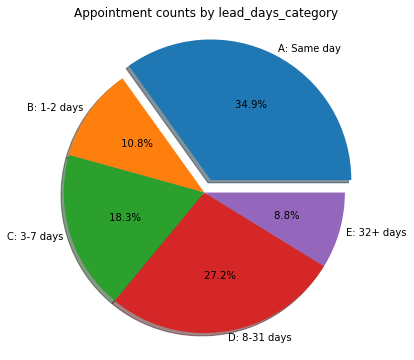

In [28]:
# Plot a pie chart for appointment counts by lead day categories
pie_data = appointments_df.lead_days_category.value_counts().sort_index()
label_list = pie_data.index
sizes = pie_data
explode_list = (0.1, 0, 0, 0, 0) 
fig1, ax1 = plt.subplots(figsize=(6, 6))
ax1.pie(
    sizes, explode = explode_list, labels = label_list, autopct =' %1.1f%%',
    pctdistance = 0.6, labeldistance = 1.05, shadow = True, startangle = 0,
    )
ax1.axis('equal') 
ax1.set_title('Appointment counts by lead_days_category')
plt.show()

Same-day appointments make up 34.9% of our entries, and as we shall see, will be an important consideration in our analysis.

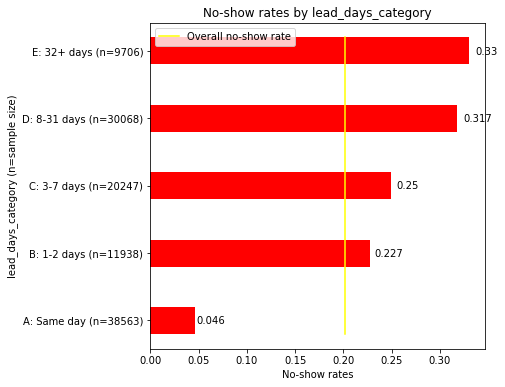

In [29]:
plot_no_show_rates(compare_by_column(appointments_df, 'lead_days_category'), 6,6)

Same day appointments have a far lower rate of no-shows than other appointments.  One possible reason is that there may be walk-in visits, counted as appointments , which will naturally be same-day appointments. 

<a id='smsvlead'></a>
### *SMS_received* and its relationship with *lead_days*
We've also found that the proportion of *SMS_received* is very much related to *lead_days*.

<div style="text-align: right"> <a href="#top">to top</a> </div>

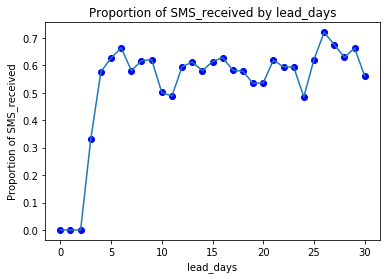

Proportion of SMS_received for lead_days > 30
0.617652726922


In [30]:
# Create a line plot of SMS_received by lead_days, up to lead_days == 30
# then print the number for the rest of the data so that they don't obscure
# the focus.
x = appointments_df.groupby('lead_days')['SMS_received'].mean()[:31].index
y = appointments_df.groupby('lead_days')['SMS_received'].mean()[:31].values
plt.plot(x,y, 'bo')
plt.plot(x,y)
plt.title('Proportion of SMS_received by lead_days')
plt.xlabel('lead_days')
plt.ylabel('Proportion of SMS_received')
plt.show()

print(bold('Proportion of SMS_received for lead_days > 30'))
print(appointments_df[appointments_df.lead_days > 30]['SMS_received'].mean())

If the appointment is 2 days away or sooner from the time it was scheduled, none of the patients received an SMS message.
Starting from *lead_days* == 3, we start to see some True values in *SMS_received*. But the ratio of *SMS_received* plateaus only at *lead_days* == 4 (or arguably 5).

As *lead_days* has a strong relationship with *no_show*, and *SMS_received* is very much related to *lead_days* when *lead_days* < 4, we must be careful when trying to establish a causal relationship between *SMS_received* and *no_show*.

A few other columns, such as *alcoholism* and *scholarship*, also seem to show patterns of their proportions varying with *lead_days* when *lead_days* are small (not shown here). Although these patterns are not as strong as that between *SMS_received* and *lead_days*, we should still bear in mind that multicollinearity may affect our analysis.

Next we'll take only the records where *lead_days* > 3, and see if those who received the SMS reminder have a different no-show rate from those who didn't.

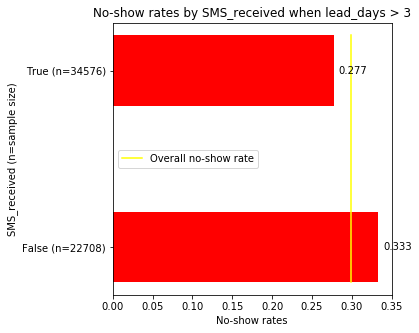

In [31]:
# Call the compare and plot functions on the SMS_received column, with 
# a trimmed dataframe that has only the entries with lead_days > 3, to 
# get around the problem that same-day appointments have a much lower
# no-show rate, and SMS messages are never sent for same-day appointments.
lead_days_3plus_df = appointments_df[appointments_df.lead_days > 3]
df_to_compare = compare_by_column(lead_days_3plus_df, 'SMS_received')
plot_no_show_rates(df_to_compare, 5, 5, ' when lead_days > 3')

Here we can see when *lead_days* > 3, those who received the SMS reminder have quite a lower no-show rate than those who didn't. 

In [32]:
print(bold('p-value: '))
print(proportions_test(
    lead_days_3plus_df[lead_days_3plus_df.SMS_received],
    lead_days_3plus_df[~ lead_days_3plus_df.SMS_received], 'no_show'
    ))

p-value: 
1.4678238877e-46


And given our sample sizes, we can confidently reject the null hypothesis that the two populations have the same no-show rate.

<a id='boolandage'></a>
### The boolean patient attributes and *age_group*

First we take a look at the no-show rates in various age groups.

<div style="text-align: right"> <a href="#top">to top</a> </div>

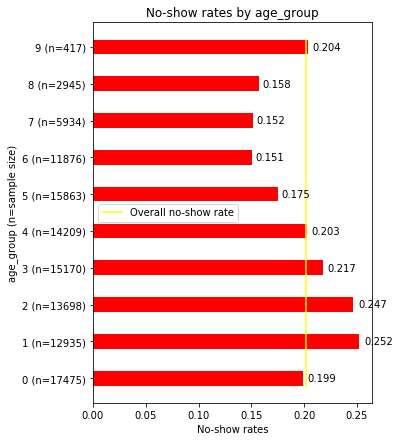

In [33]:
plot_no_show_rates(compare_by_column(appointments_df, 'age_group'), 5, 7)

We can see that age groups 1 and 2 (age 10 to 29) have higher no-show rates than the overall rate, whil groups 5 to 8 (age 50 to 89) have lower rates. Group 0 (age -1 to 9) has a no-show rate close to the overall rate.

One possible explanation of the S-shaped pattern is that younger patients who visit the hospital on their own somehow tend to miss their appointments more often. But the children in group 0 are usually accompanied by adults - whose age can be diverse - and that these adults ultimately determine whether the appointment was kept.

Next we'll see the no-show rates of patient groups with various features.

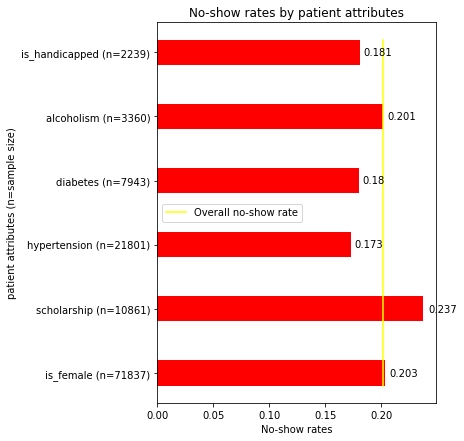

In [34]:
# Create a bar chart for all booleans
column_list = [
    'is_female', 'scholarship', 'hypertension', 'diabetes', 'alcoholism',
    'is_handicapped'
    ]
comparison_df = compare_by_multiple_booleans(appointments_df, column_list)
plot_no_show_rates(comparison_df, 5, 7)

*hypertension*, *diabetes* and *is_handicapped* seems to be related to lower no-show rates, while patients enrolled in Bolsa Família (*scholarship*) were less likely to keep their appointments.

Note that, as we shall see, most of these features are related to *age_group*.

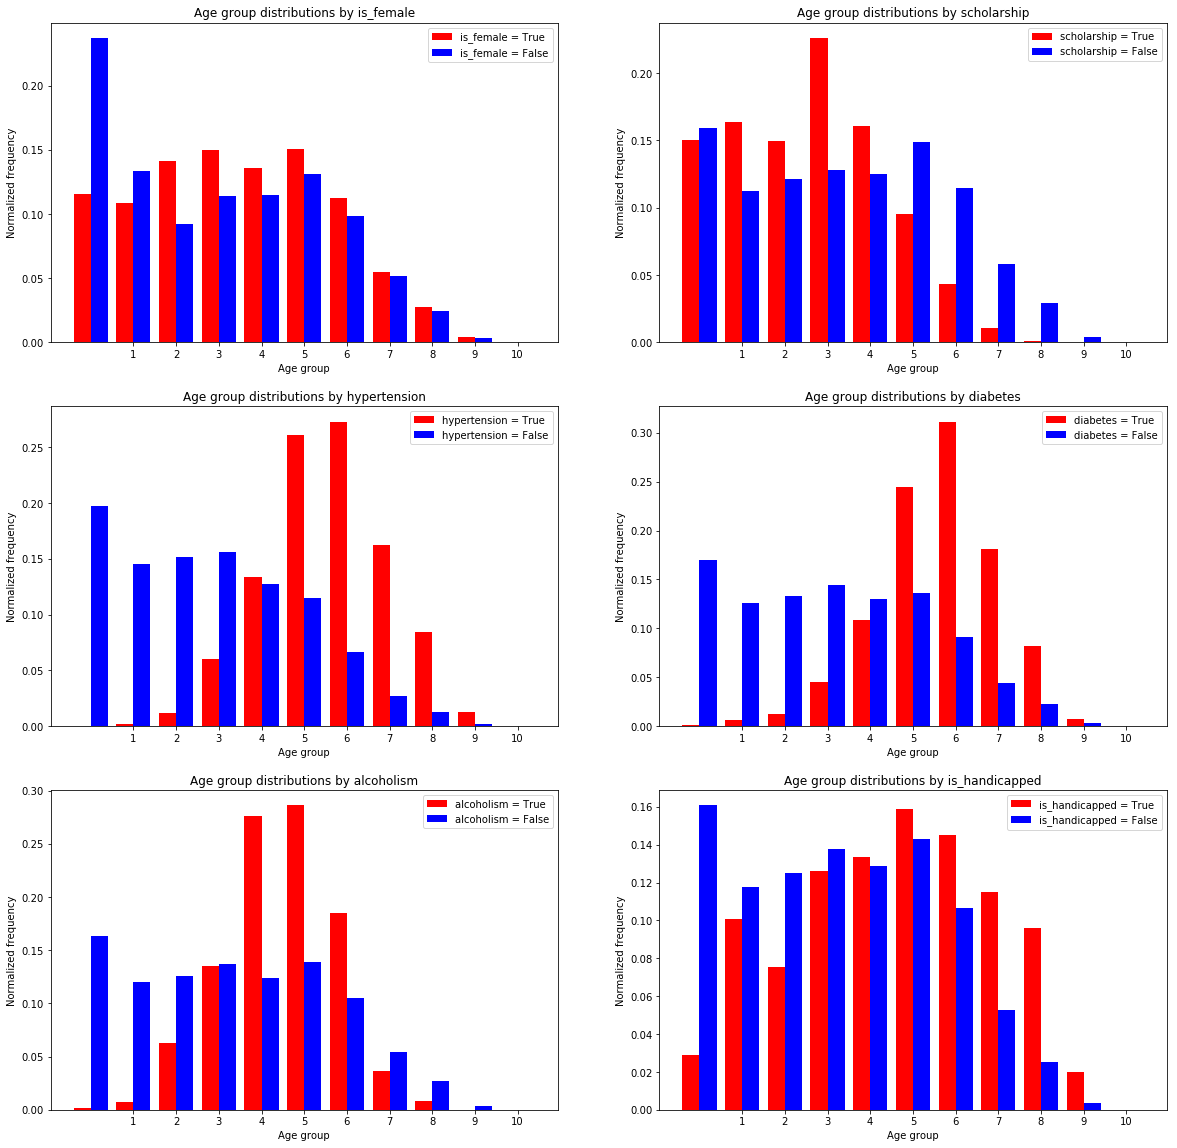

In [35]:
def booleans_by_age_group(column, grid_number):
    '''
    Takes a column name and subplot grid number, and plots the column
    by age_group
    '''
    ax = fig.add_subplot(grid_number)
    red_x = appointments_df[appointments_df[column]].age_group
    blue_x = appointments_df[~ appointments_df[column]].age_group
    ax.hist(
        [red_x, blue_x], normed = True, color = ['red', 'blue'],
        bins = np.arange(12), align = 'left'
        )
    ax.set_xticks(np.arange(1,11))
    ax.set_ylabel('Normalized frequency')
    ax.set_xlabel(('Age group'))
    ax.set_title('Age group distributions by ' + column)
    ax.legend((column + ' = True', column + ' = False'))
    return

fig = plt.figure(figsize=(20,20))
booleans_by_age_group('is_female', 321)
booleans_by_age_group('scholarship', 322)
booleans_by_age_group('hypertension', 323) 
booleans_by_age_group('diabetes', 324)
booleans_by_age_group('alcoholism', 325)
booleans_by_age_group('is_handicapped', 326)
plt.show()

The frequency distributions among different age groups obviously change together with the values of the columns *scholarship*, *hypertension*, *diabetes* and *alcoholism*.

Coincidentally, the attributes that are related to lower no-show rates - *handicap*, *diabetes* and *hypertension* - have distributions concentrated more at older ages; while *scholarship* is related to higher no-show rates and is more concentrated in the younger age groups.

How much of the variance in *no_show* can be explained by age, and how much by these attributes, can only be answered by more in-depth analysis or statistical modeling.

<a id='history'></a>
### No-show history
It is also found that among patients who have a previous appointment record in our data set, those who failed to show up the last time have a much higher frequency of failing again to show up, than those who kept their last appointment.

<div style="text-align: right"> <a href="#top">to top</a> </div>

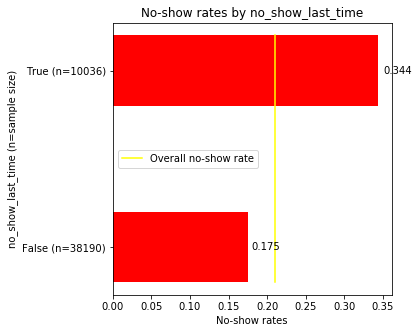

In [36]:
plot_no_show_rates(
    compare_by_column(appointments_df, 'no_show_last_time'), 5, 5
    )

We'll run a z-test on the null hypothesis that the two populations have the same no-show rate

In [37]:
print(bold('p-value: '))
print(proportions_test(
    appointments_df[appointments_df.no_show_last_time == True],
    appointments_df[appointments_df.no_show_last_time == False], 
    'no_show'
    ))

p-value: 
1.26056191842e-297


We can reject the null hypothesis that the two populations should have the same no-show rate.

However, note that whether the patient's last appointment record is included in our data set may be related to how likely they will miss two appointments in a row. 

For example, if a patient has two appointments at two departments scheduled on the same day, and if they miss one they are likely to miss the other. And since both appointments are on the same day, either both will be in our data set, or neither.

But when a patient misses an appointment and calls to reschedule, the probability of them missing the next one may not be related to them having missed the first, and if the appointment is rescheduled on a different day, the first appointment could end up outside of our data set while the second one is included.

Therefore it is dangerous to conclude just from our test that when one misses an appointment, he is more likely than average to miss the next.

Nonetheless, past no-show history seems like a interesting feature to look into, if in the future we are to build models to predict no-shows.


<a id='hour'></a>
### No-show rates by *scheduled_hour*
Distribution of *scheduled_hour* values are quite different between same-day appointments and other cases. 

Since same-day appointments have such a low no-show rate, compared to the overall rate, in this section we'll take a look at no-show proportions by *scheduled_hour*, but only including the rows where *lead_days* > 0.

<div style="text-align: right"> <a href="#top">to top</a> </div>

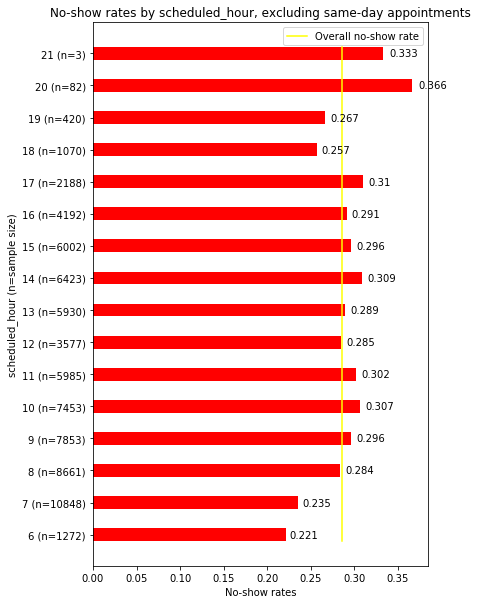

In [38]:
# Plot no-show proportions by scheduled_hour, only for rows where
# lead_days > 0
comparison_df = compare_by_column(
    appointments_df[appointments_df.lead_days > 0], 'scheduled_hour'
    )
plot_no_show_rates(
    comparison_df, 6, 10, title_suffix = ', excluding same-day appointments'
    )

It looks like there is some relationship between the hour in which the appointment is scheduled, and whether the patient is going to show up.

Apparently, patients who scheduled their appointment before 08:00 showed up more often than others.

Note that for *scheduled_hour* values 20 and 21, the sample sizes are quite small.

<a id='neighbourhoodvnoshow'></a>
### No-show rates by *neighbourhood*

Different neighbourhoods (hospitals) also exhibit different no-show rates.

<div style="text-align: right"> <a href="#top">to top</a> </div>

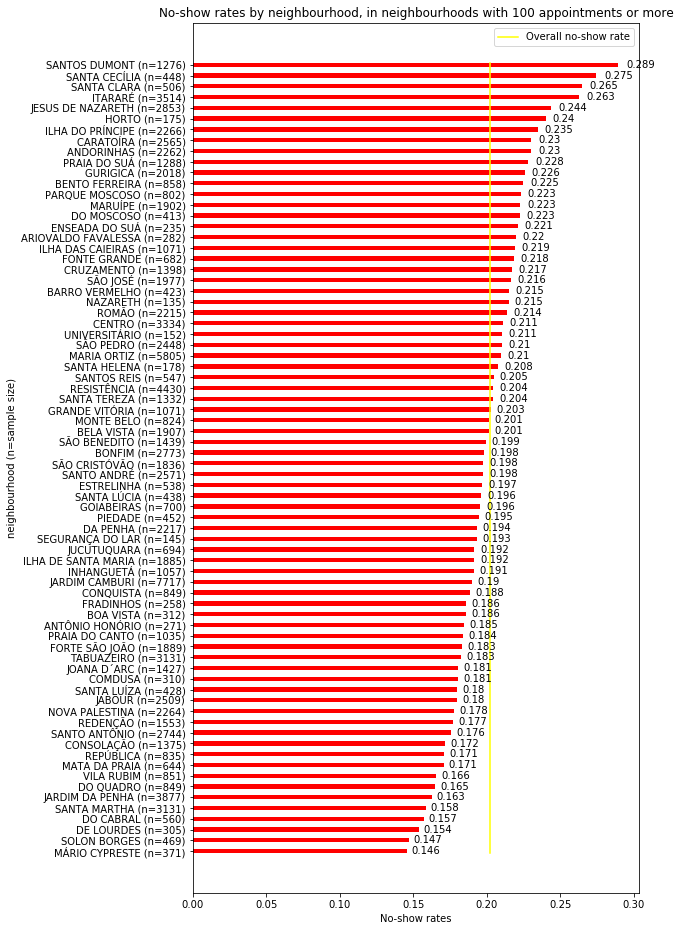

In [39]:
# Create a comparison_df with the neighbourhood column
neighbourhood_df = compare_by_column(appointments_df, 'neighbourhood')
# Take away rows with sample_size less than 100 to get rid of possible 
# extreme values that could be caused by small sample sizes, then sort
# to make the graph look better.
neighbourhood_df = (
    neighbourhood_df[neighbourhood_df.sample_size >= 100]
    .sort_values('no_show_rate')
    )
neighbourhood_df.sample_size = neighbourhood_df.sample_size.astype(int)
neighbourhood_df.name = 'neighbourhood'
plot_no_show_rates(
    neighbourhood_df, 8, 16, ', in neighbourhoods with 100 appointments or more'
    )

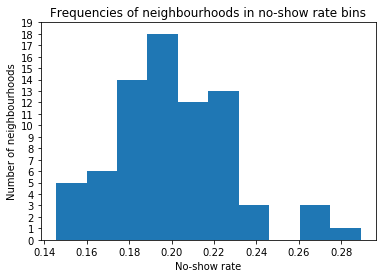

In [40]:
plt.hist(neighbourhood_df.no_show_rate)
plt.yticks(range(0,20))
plt.title('Frequencies of neighbourhoods in no-show rate bins')
plt.ylabel('Number of neighbourhoods')
plt.xlabel('No-show rate')
plt.show()

This graph includes 75 of the 81 *neighbourhood* values in our data set. 6 were excluded because they have fewer than 100 appointments and can be affected by sampling variance too much.

Some of the *neighbourhood* values had a no-show rate of 0.26 or more, while a few on the low end were around 0.16. This may indicate that the underlying population no-show rates are different for at least some of the neighbourhoods.

<a id='conclusions'></a>
## Conclusions

We have looked at most of the columns in our data set. Some of them show relationships with whether the patient showed up to the appointment, to various degrees, and also between themselves.

*SMS_received*, *lead_days* (number of days between the appointment and when it was scheduled), and *no_show* exhibit interrelationships. This will be an important consideration in further studies on the prediction of *no_show*.

*age_group* also seems to be related to no_show, but probably not monotonically. Like the previous finding, various boolean attributes like *diabetes* and *hypertension* exhibit interrelationships together with *age_group* and *no_show*.

In these feature groups, only by statistical modeling can we tell which features explain or predict *no_show* the best, and that is beyond the scope of this study.

We have also looked at *no_show_last_time*, i.e. whether the patient missed his last appointment in our data set. This column has a lot of missing values because our data set spans only a little more than a month and many patients don't have a previous appointment record. However, we found that among the data points we have, those who missed an appointment showed a much higher frequency of also missing the next.

If prediction is to be modeled with a bigger data set, no-show history or some variant of it should be an interesting feature to include.

Finally we also investigated *scheduled_hour* (the hour in which the appointment was scheduled) as well as *neighbourhood* (of the hospital). Both seem to have at least some values that show different no-show rates than the average.

The investigation carried out in this study is exploratory and is meant to provide insights for further analysis. A few of the limitations of this study are:
* Interrelationship between features are not sufficiently investigated. Multicollinearity is not accounted for.
* Some features may have a non-linear relationship with *no_show* and we have barely looked at that. 
* It lacks the precision a statistical model can give us, in the magnitude of each of the feature coefficients and in the overall predictive power of the model.  

Therefore the findings should not be interpreted as a predictive model, or any other means to make predictions.

The data set contains a lot of information that will likely help predict whether a patient is going to show up to an appointment. To make accurate predictive models and draw better conclusions, more in-depth analysis is needed, and will be helped by using a bigger data set spanning a longer period of time.
<div style="text-align: right"> <a href="#top">to top</a> </div>

## Follow up
Perform a random forest prediction and find the feature importance.
Exercise for Xccelerate 2018/11/08.

In [69]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble

# rename to save typing time :P
df = appointments_df

In [70]:
# convert these two variables into categorical, as neither of them have any order
# in the values.
df = pd.concat([df, pd.get_dummies(df.neighbourhood, prefix='neighbourhood', drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df.scheduled_hour, prefix='hour', drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df.appointment_DOW, prefix='dow', drop_first=True)], axis=1)

In [71]:
df.columns

Index(['patient_ID', 'gender', 'scheduled_day', 'appointment_day', 'age',
       'neighbourhood', 'scholarship', 'hypertension', 'diabetes',
       'alcoholism',
       ...
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'dow_1', 'dow_2',
       'dow_3', 'dow_4', 'dow_5'],
      dtype='object', length=121)

In [80]:
# no scaling required as trees are insensitive to scale

clf = ensemble.RandomForestClassifier(random_state=42)
features_list = [
    'age', 'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'is_handicapped',
    'SMS_received', 'lead_days', 'is_female', 'neighbourhood',
    'scheduled_hour', 'appointment_DOW'
]
drop_list = [
    'patient_ID', 'gender', 'scheduled_day', 'appointment_day', 'neighbourhood', 'no_show',
    'scheduled_hour', 'lead_days_category', 'age_group', 'no_show_last_time'
]


features_train, features_test, labels_train, labels_test = \
    train_test_split(df.drop(drop_list, axis=1), df.no_show, test_size=0.3, random_state=42)
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print(metrics.classification_report(labels_test, pred))
print(metrics.confusion_matrix(labels_test, pred))


             precision    recall  f1-score   support

      False       0.82      0.95      0.88     26398
       True       0.44      0.17      0.24      6759

avg / total       0.74      0.79      0.75     33157

[[24960  1438]
 [ 5618  1141]]


In [122]:
feature_importances = {}
for i in range(len(df.drop(drop_list, axis=1).columns)):
    feature_importances[df.drop(drop_list, axis=1).columns.values[i]] = clf.feature_importances_[i]
importance_df = pd.DataFrame(feature_importances, index=[0]).transpose()
importance_df = importance_df.sort_values(by=0, ascending=False)
importance_df.index.name = 'feature_importance'
importance_df

,0
feature_importance,
lead_days,0.220147
age,0.219499
appointment_DOW,0.032109
is_female,0.031956
SMS_received,0.023192
...,...
neighbourhood_ILHA DO BOI,0.000080
neighbourhood_ILHA DO FRADE,0.000055
neighbourhood_ILHAS OCEÂNICAS DE TRINDADE,0.000043
